In [35]:
from skimage.segmentation import active_contour
from skimage import filters, segmentation, feature
from skimage.draw import polygon
from skimage.measure import label
from matplotlib.colors import to_rgba
from skimage.measure import regionprops
from skimage.feature import canny
from skimage.measure import find_contours
from skimage import measure, segmentation
import scipy.io
import matplotlib.pyplot as plt
import math
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import numpy as np
import numpy.testing as testing
import cv2
from skimage import morphology, segmentation
from keras.layers import Cropping2D, ZeroPadding2D, Input
from matplotlib.colors import ListedColormap
from skimage.filters import threshold_multiotsu

In [36]:
cmap = ListedColormap(['darkblue', 'skyblue', 'blue', 'yellow', 'darkorange', 'darkred'])

# User-defined labels for markers
labels = {
    0: 'Air',
    1: 'Skin/Scalp',
    2: 'Skull',
    3: 'CSF',
    4: 'Gray Matter',
    5: 'White Matter'
}

In [37]:
def grayscale_to_colored(segmented_image, cmap, labels):
    """
    Convert a grayscale segmented image to a colored image using a user-defined colormap.
    
    Parameters:
    segmented_image (ndarray): Grayscale segmented image.
    cmap (ListedColormap): User-defined colormap.
    labels (dict): Dictionary mapping label indices to label names.
    
    Returns:
    ndarray: Colored segmented image.
    """
    colored_image = cmap(segmented_image)
    return colored_image

# Example usage:
# Assuming 'segmented_image' is a grayscale segmented image represented as a numpy array


In [38]:
def compute_binary_mask(image, tissue_label):
    binary_mask = np.where(image == tissue_label, 1, 0)
    return binary_mask


In [39]:
def dice_coefficient(segmented_image, ground_truth):
    """
    Computes the Dice coefficient for evaluating segmentation performance.
    
    Parameters:
    segmented_image (ndarray): Binary image representing the segmented edges.
    ground_truth (ndarray): Binary image representing the ground truth edges.
    
    Returns:
    float: Dice coefficient value.
    """
    dice_array = []
    for tissue_label in range(0,6):
        binary_segmented_image= compute_binary_mask(segmented_image, tissue_label)
        binary_ground_truth= compute_binary_mask(ground_truth, tissue_label)
        intersection = np.sum(binary_ground_truth & binary_segmented_image)
        dice_coefficient = 0.0
        if np.sum(binary_ground_truth) + np.sum(binary_segmented_image) > 0:
            dice_coefficient_per_slice = (2.0 * intersection) / (np.sum(binary_ground_truth) + np.sum(binary_segmented_image))
    
        dice_array.append(dice_coefficient_per_slice)
    
    dice = np.mean(dice_array) # Add a small value to avoid division by zero
    
    return dice

In [40]:
def precision(ground_truth, segmented_image):
    tp = np.sum((segmented_image == 1) & (ground_truth == 1))
    fp = np.sum((segmented_image == 1) & (ground_truth == 0))
    if (tp+fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
        
    return precision

In [41]:

def precision_per_slice(segmented_image, ground_truth):
    """
    Computes the Dice coefficient for evaluating segmentation performance.
    
    Parameters:
    segmented_image (ndarray): Binary image representing the segmented edges.
    ground_truth (ndarray): Binary image representing the ground truth edges.
    
    Returns:
    float: Dice coefficient value.
    """
    precision_val = []
    for tissue_label in range(0,6):
        binary_segmented_image= compute_binary_mask(segmented_image, tissue_label)
        binary_ground_truth= compute_binary_mask(ground_truth, tissue_label)
        precision_val.append(precision(binary_ground_truth, binary_segmented_image))

    precision_per_slice = np.mean(precision_val)
    return precision_per_slice

In [42]:
def pre_processing(image):
    min_value = np.min(image)
    max_value = np.max(image)
    normalized_image = ((image - min_value) / (max_value - min_value)) *255
    if max_value != 0:
        normalized_arr = normalized_image
    else:
        normalized_arr = image  # Handles case when max_value is 0 to avoid division by zero
    image = normalized_arr

    return image

In [43]:
def thresholding_per_slice(image, ground_truth):
    # 1. Apply Thresholding
    # Determine thresholds for segmenting the image into 6 layers
    thresholds = threshold_multiotsu(image, classes=6)
    
    # 2. Segment the Image
    # This will create a segmented image where each pixel value represents a tissue layer [0-5]
    segments = np.digitize(image, bins=thresholds, right=True) - 1
    print(segments)
    # User-defined colormap and labels
    cmap = ListedColormap(['darkblue', 'skyblue', 'blue', 'yellow', 'darkorange', 'darkred'])
    labels = {
        0: 'Air',
        1: 'Skin/Scalp',
        2: 'Skull',
        3: 'CSF',
        4: 'Gray Matter',
        5: 'White Matter'
    }
    
    # 3. Visualize with Colormap
    plt.figure(figsize=(8, 8))
    plt.imshow(segments, cmap=cmap)
    plt.colorbar(ticks=range(6), label='Tissue Layer')
    plt.clim(-0.5, 5.5)  # Ensure colorbar aligns with the discrete segments
    plt.title('Thresholded Image')
    # 3. Visualize with Colormap
    plt.figure(figsize=(8, 8))
    plt.imshow(ground_truth, cmap=cmap)
    plt.colorbar(ticks=range(6), label='Tissue Layer')
    plt.clim(-0.5, 5.5)  # Ensure colorbar aligns with the discrete segments
    plt.title('Ground Truth Image')
    # 4. Apply Labels
    # Create a custom legend for the labels
    # Generate patches for the legend
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color=cmap(i), label=label) for i, label in labels.items()]
    
    # Add the legend to the plot
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    return segments


In [44]:
def thresholding_for_dataset():
    mat_data = scipy.io.loadmat('Brain.mat')
    # Extract the MRI slices and presegmented images
    mri_slices = mat_data['T1']
    segmented_slices = mat_data['label']
    dice_coefficient_array = []
    precision_array = []
    for index in range(0,10):
        image = pre_processing(mri_slices[:,:,index])
        ground_truth = segmented_slices[:,:,index]
        thresholding_per_image = thresholding_per_slice(image, ground_truth)
        #colored_image_threshold = grayscale_to_colored(thresholding_per_image, cmap, labels)
        #colored_image_gt= grayscale_to_colored(ground_truth, cmap, labels)
        precision_threshold = precision_per_slice(thresholding_per_image, ground_truth)
        precision_array.append(precision_threshold)

        dice_coefficient_threshold = dice_coefficient(thresholding_per_image, ground_truth)
        dice_coefficient_array.append(dice_coefficient_threshold)
    precision_dataset = np.mean(precision_array)
    dice_coefficient_dataset= np.mean(dice_coefficient_array)
    print("Dice coefficient of multi otsu thresholding: ", np.mean(dice_coefficient_dataset))
    print("Precision for multi otsu thresholding: ", np.mean(precision_dataset))



[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


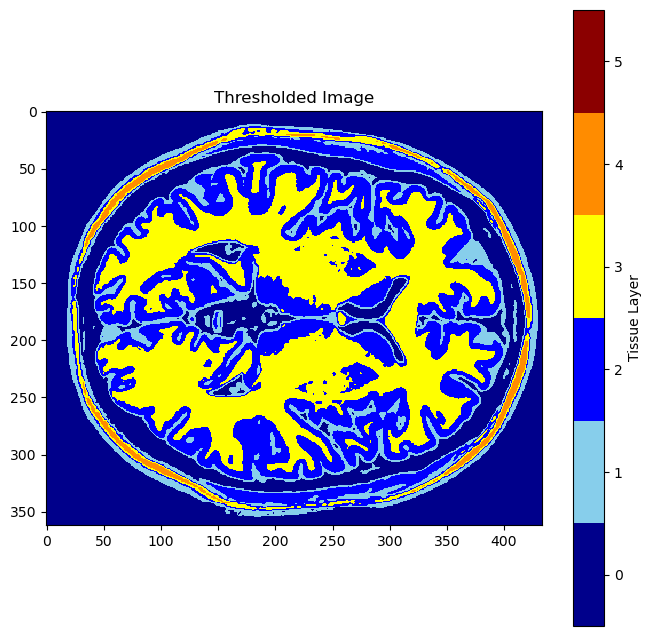

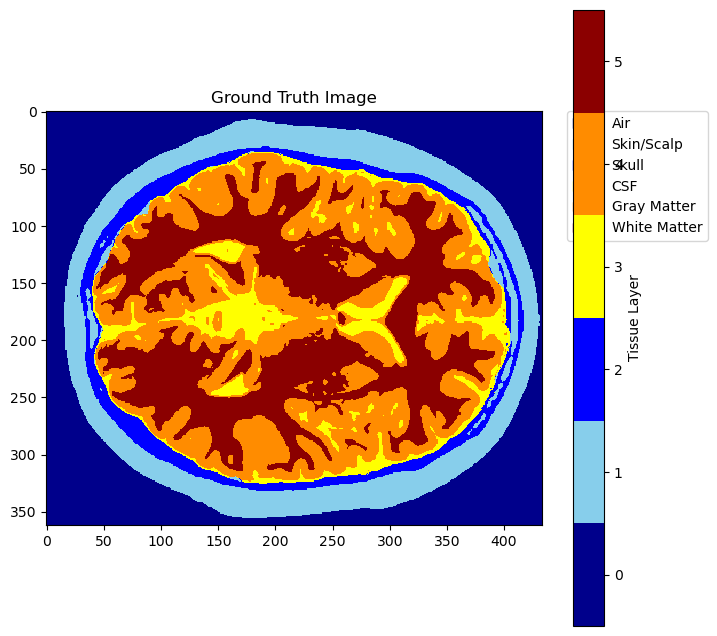

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


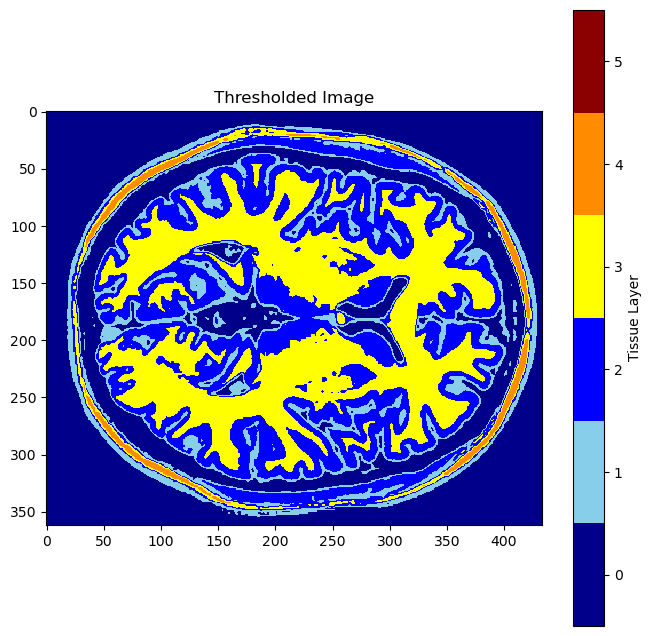

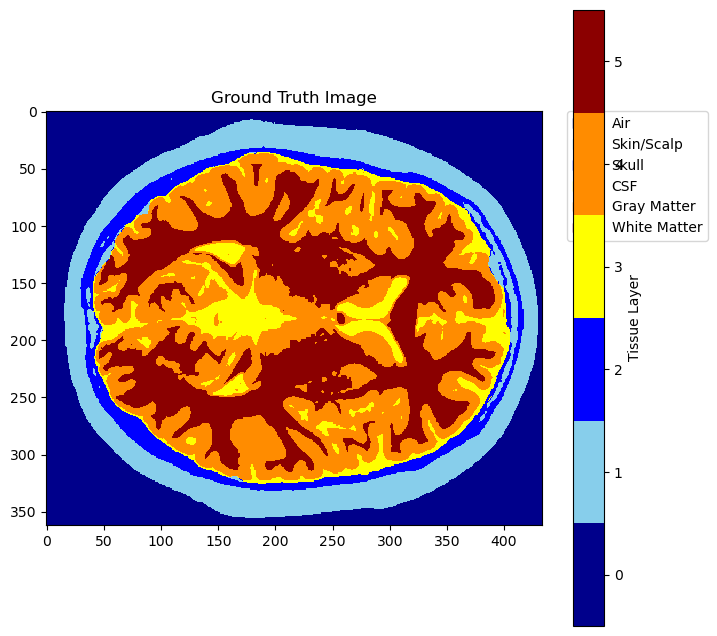

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


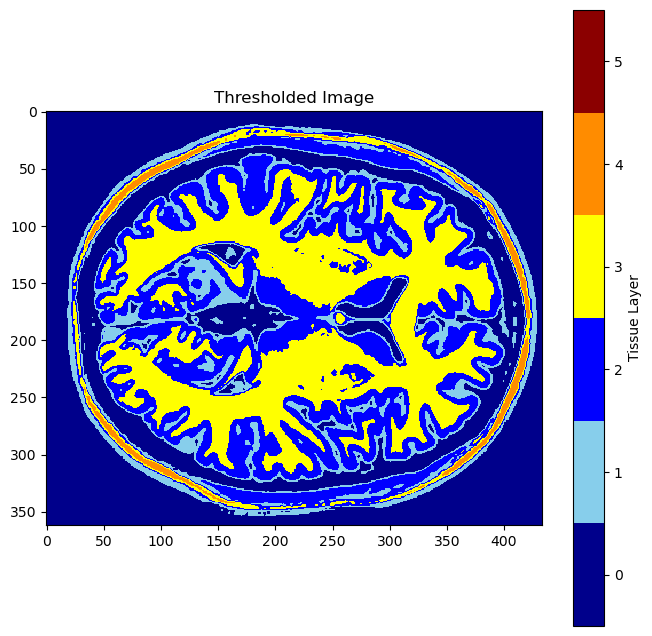

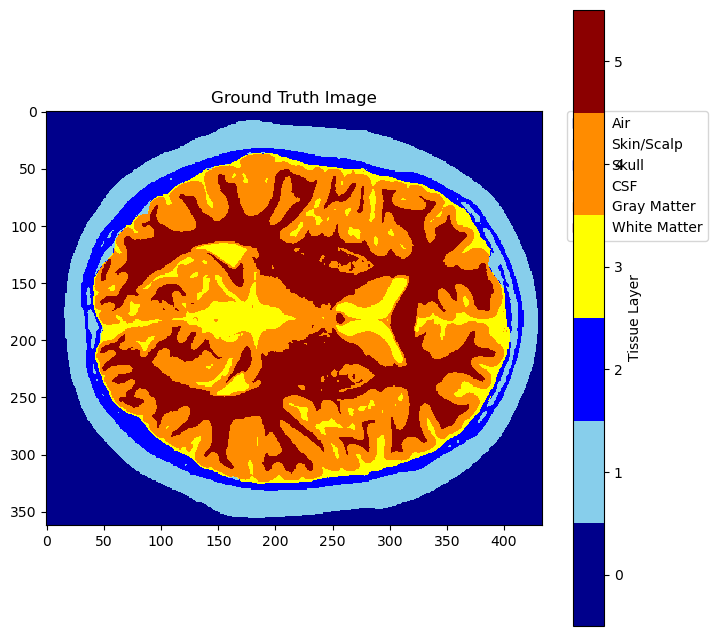

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


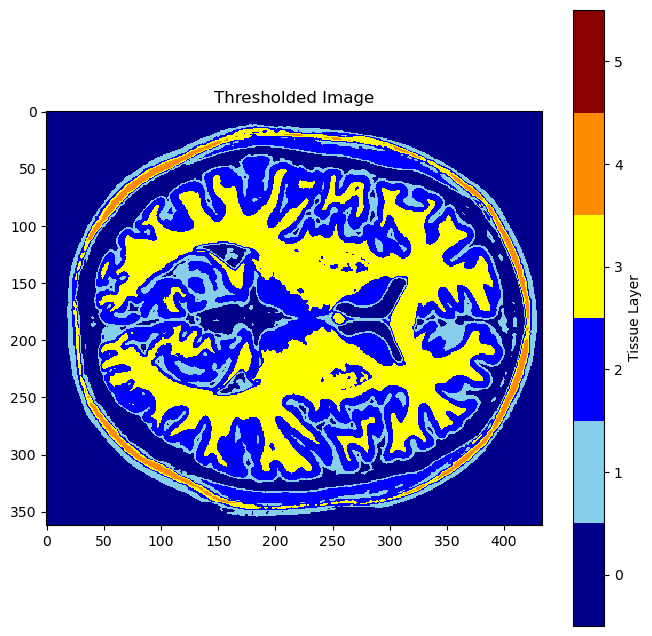

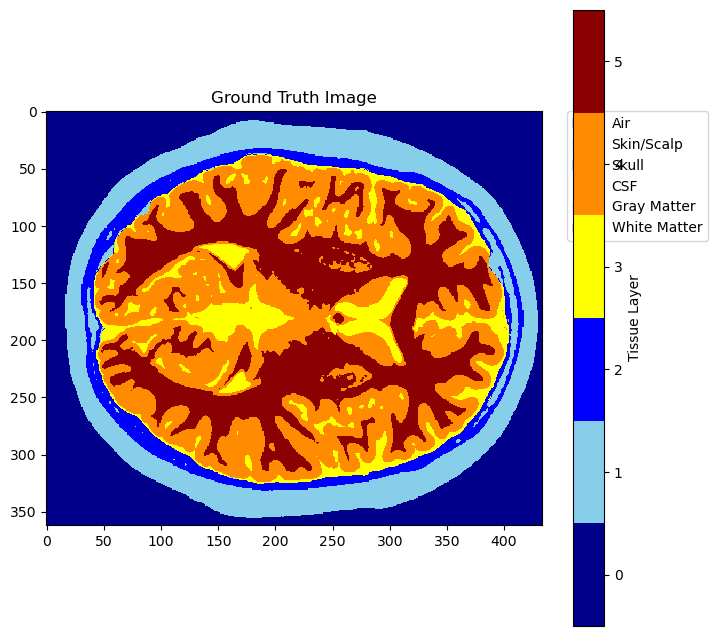

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


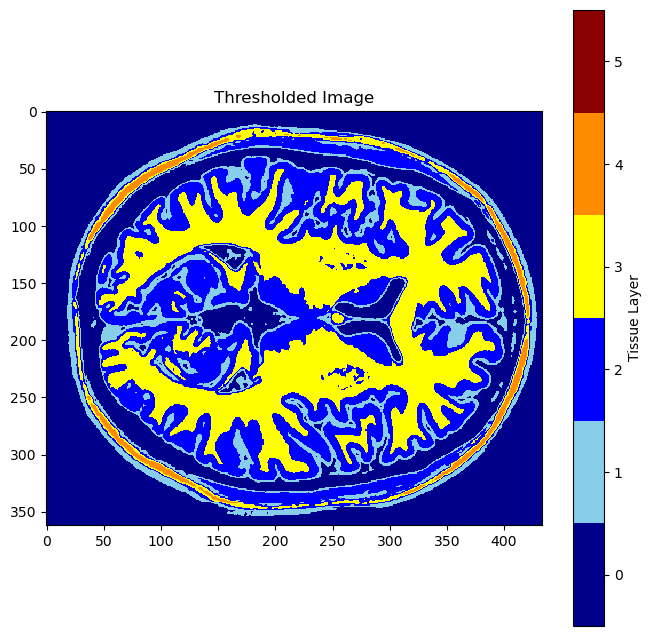

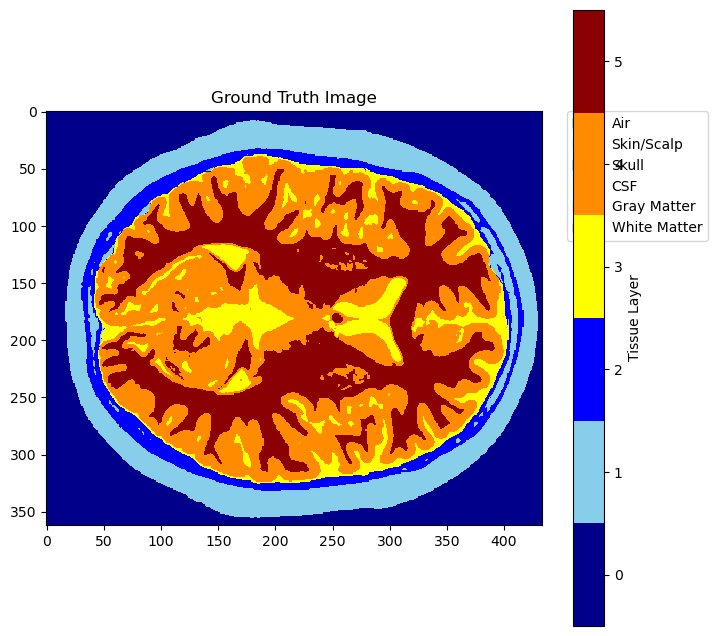

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


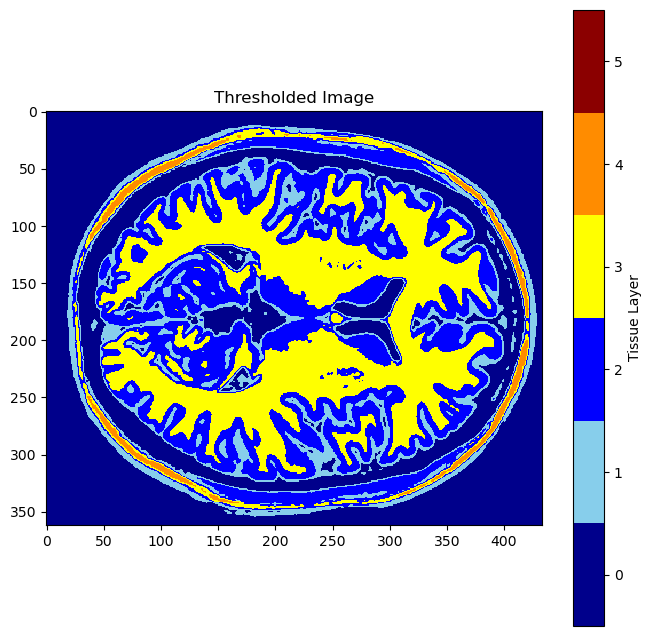

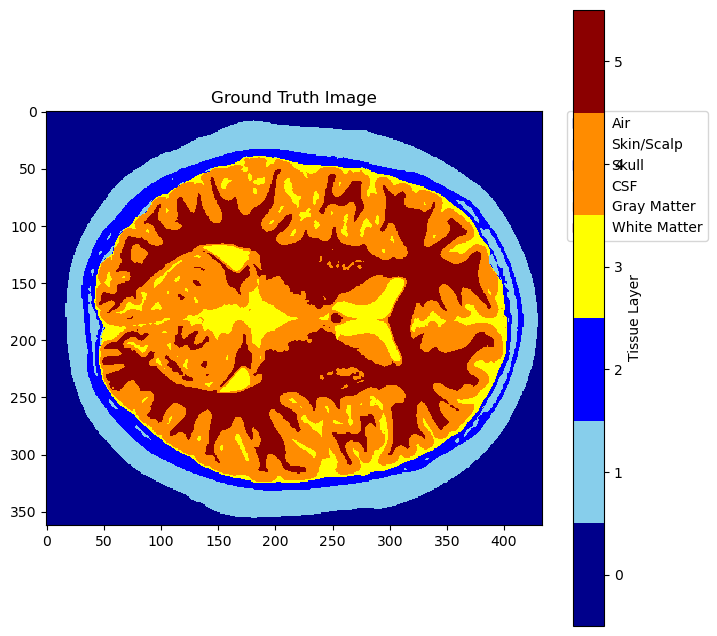

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


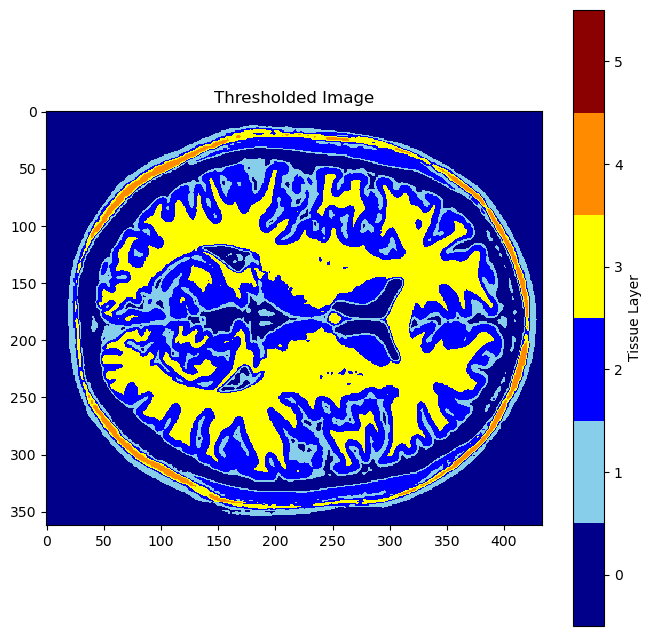

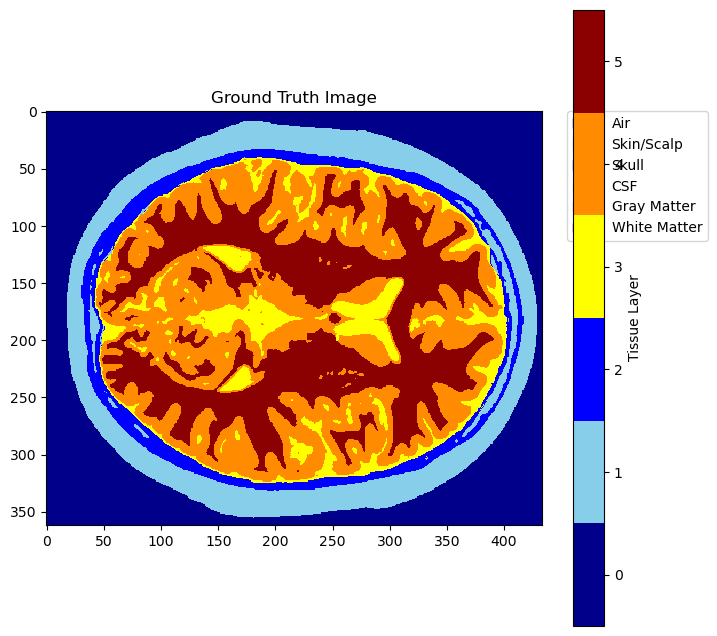

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


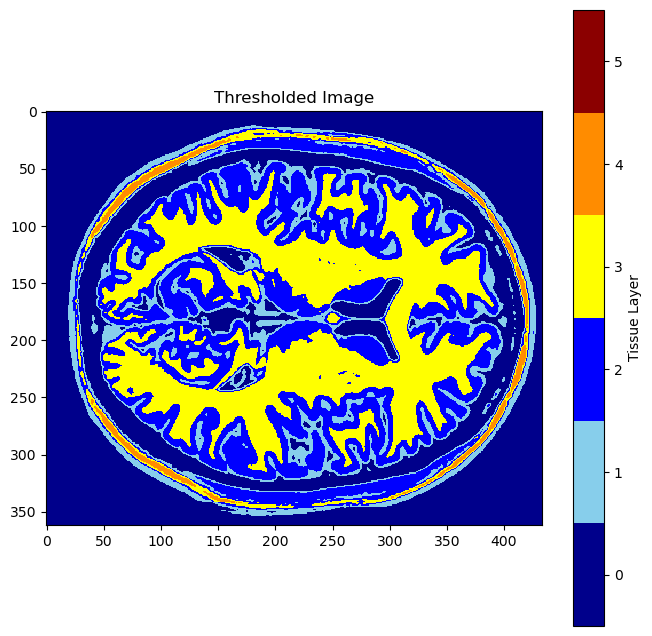

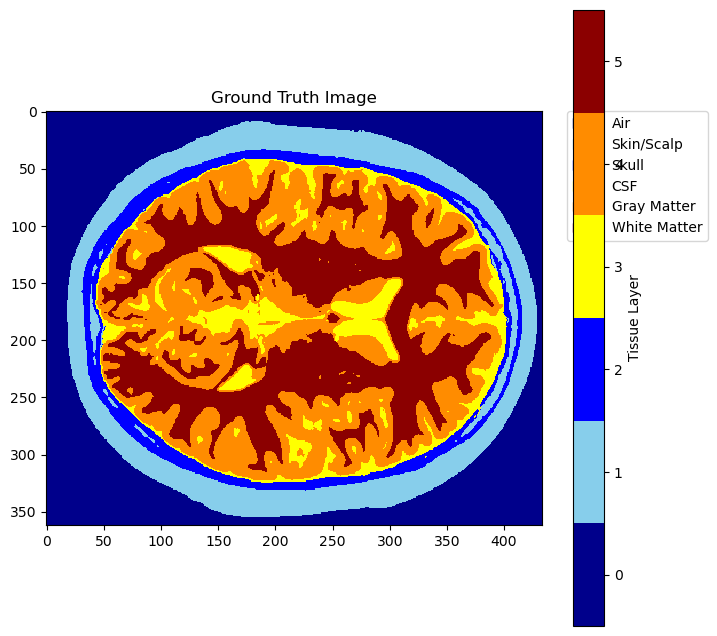

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


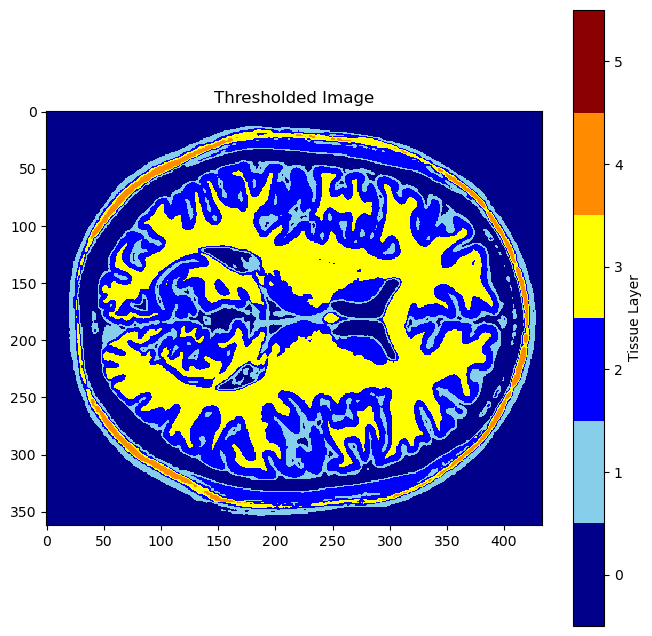

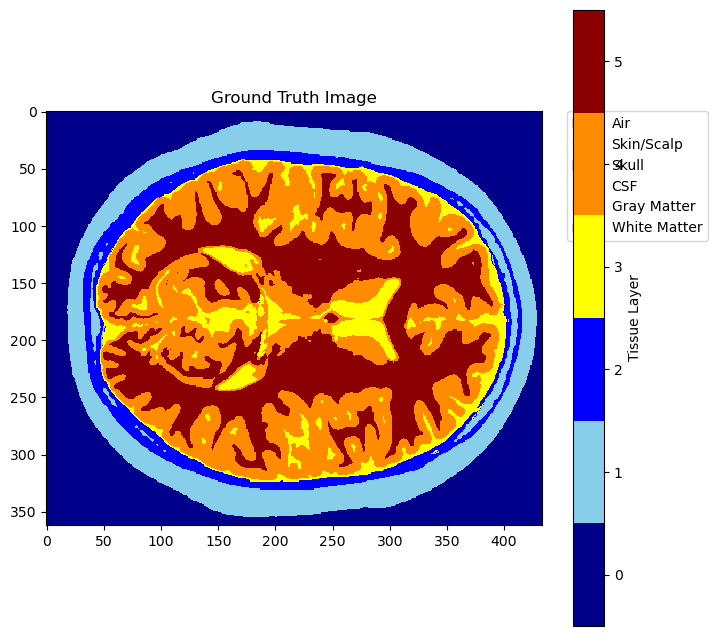

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


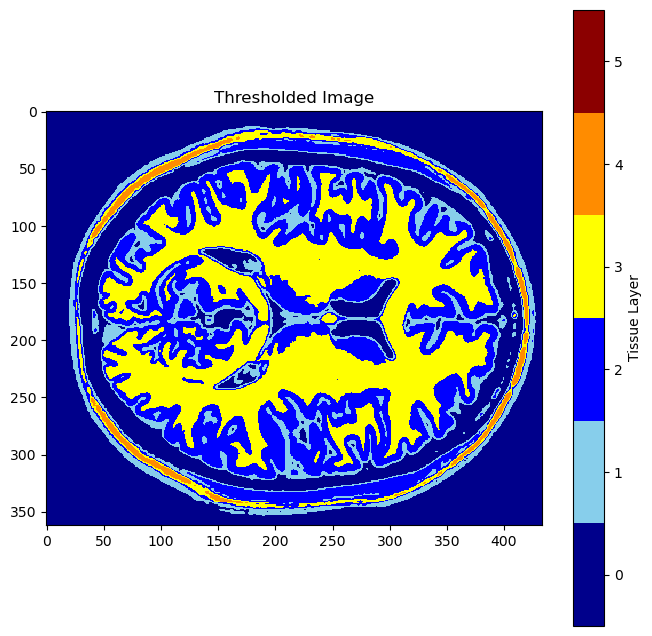

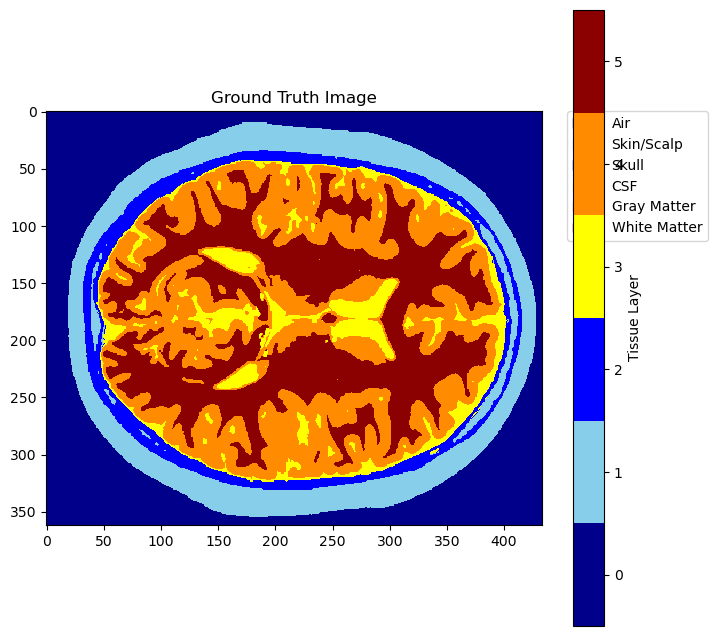

Dice coefficient of multi otsu thresholding:  0.0641475644805394
Precision for multi otsu thresholding:  0.08002746425872229


In [45]:
thresholding_for_dataset()